In [5]:
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats


Current data is shaped: (1250, 100, 514)


Text(0, 0.5, 'Calibrated reflectance')

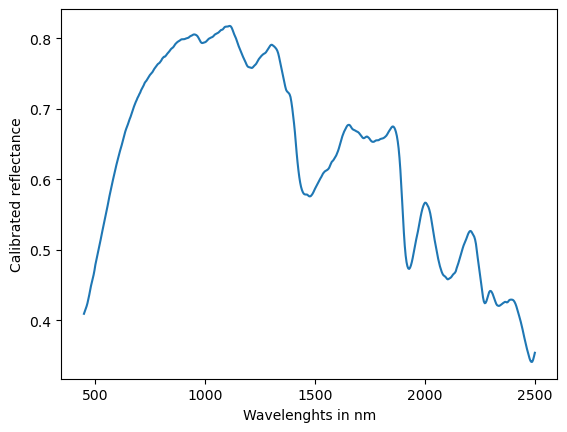

In [4]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 10
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')

Chose Boxcar length 10%


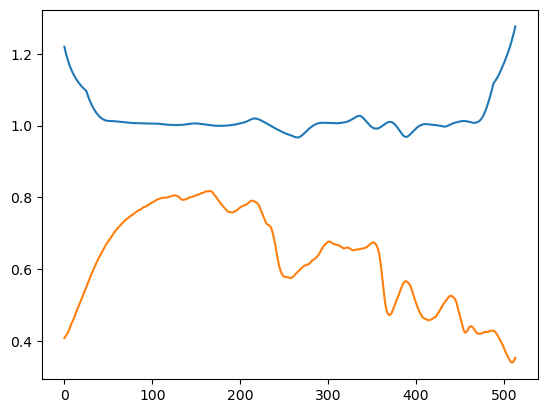

In [43]:
# Boxcar filtering

def boxcar_filtering(input_spectrum, filter_size):
    """
    Apply boxcar filter on the input spectrum.
    """
    box = signal.boxcar(filter_size)
    filtered_spectrum = signal.convolve(input_spectrum, box, mode='same') / filter_size
    return filtered_spectrum


b1 = boxcar_filtering(curr_pixel,
                      int(0.1 * len(curr_pixel)))
b2 = boxcar_filtering(curr_pixel,
                      int(0.02 * len(curr_pixel)))

b11 = boxcar_filtering(b1,
                      int(0.1 * len(b1)))

b21 = boxcar_filtering(b2,
                      int(0.02 * len(b2)))

aux1 = np.std(b11 - b1)
aux2 = np.std(b21 - b2)

if aux1 >= aux2:
    aux3 = b1 / b11
    print('Chose Boxcar length 10%')
else:
    aux3 = b2 / b21
    print('Chose Boxcar length 2%')
    
plt.plot(aux3)
plt.plot(curr_pixel)

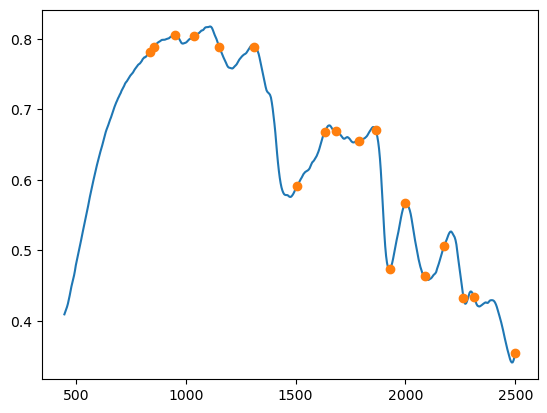

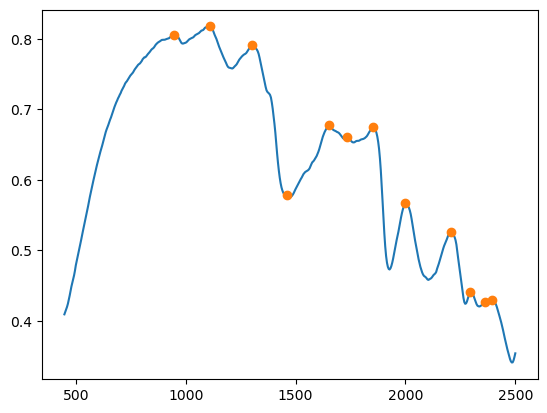

In [98]:
from scipy.interpolate import interp1d

# Extract absorption peaks
def extract_absorption_peaks(spectrum):
    # Assuming the spectrum is a 1D numpy array
    # We find the indices where the derivative changes sign - these are the peaks
    peaks = np.where(np.diff(np.sign(np.gradient(spectrum))))[0]
    return peaks

peaks = extract_absorption_peaks(aux3)
# Try adding on the final index of the spectrum
peaks = np.append(peaks, aux3.shape[0]-1)


plt.plot(wav_array, curr_pixel)
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

from scipy.signal import find_peaks, find_peaks_cwt
test_peaks = find_peaks(curr_pixel)[0]

plt.figure()
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array[test_peaks],
         curr_pixel[test_peaks],
         'o')
# find_peaks_cwt?


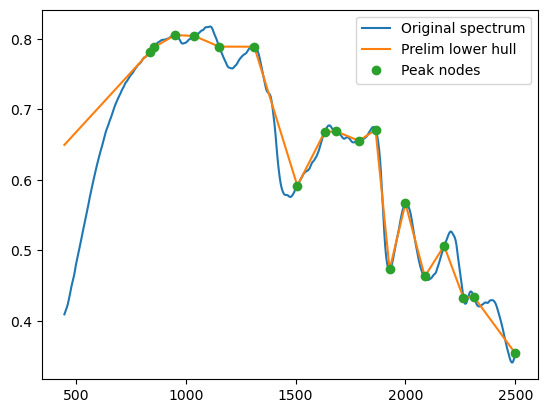

In [99]:
# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull

lower_hull = interpolate_linear(curr_pixel,
                                peaks)

plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, lower_hull)
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')
plt.legend(['Original spectrum', 'Prelim lower hull', 'Peak nodes'])

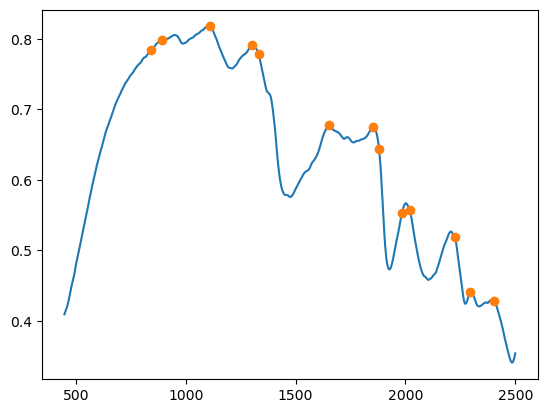

In [100]:
# Make a set of segments from the interpolation
lower_hull_diff = curr_pixel - lower_hull

def max_in_non_zero_segments(array, indices):
    """
    This function finds the maximum in each non-zero segment of an array.
    Segments are defined as ranges between two indices.
    
    Parameters:
    array (numpy array): The array to find the maximum in each non-zero segment.
    indices (numpy array): The indices defining the segments.

    Returns:
    list: A list of tuples, where each tuple contains the index of the maximum value and the maximum value itself for each non-zero segment.
    """
    
    max_indices = []
    
    # Iterate over the indices
    for i in range(len(indices) - 1):
        # Define the segment
        segment = array[indices[i]:indices[i+1]]
        
        # Ignore zero segments
        if np.count_nonzero(segment) == 0:
            continue
        
        # Find the maximum value in the segment
        max_value = np.max(segment)
        
        if max_value == 0:
            continue
        
        # Find the index of the maximum value in the segment
        max_index = np.argmax(segment) + indices[i]
        
        max_indices.append(max_index)
    
    return np.asarray(max_indices)

seg_array = max_in_non_zero_segments(lower_hull_diff, peaks)

plt.plot(wav_array, curr_pixel)
plt.plot(wav_array[seg_array], curr_pixel[seg_array], 'o')

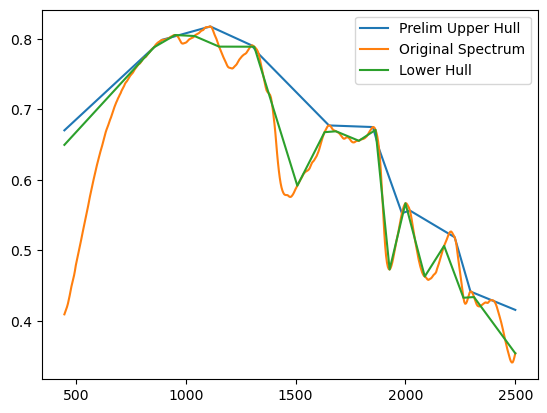

In [101]:
upper_hull = interpolate_linear(curr_pixel, seg_array)

plt.figure()
plt.plot(wav_array, upper_hull)
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, lower_hull)

plt.legend(['Prelim Upper Hull', 'Original Spectrum', "Lower Hull"])

prelim_indices = seg_array

In [115]:

def check_zero_crossings(point_set1, point_set2):
    """
    This function checks for zero crossings between two point sets.
    A zero crossing occurs when the difference between the two point sets changes sign.
    
    Parameters:
    point_set1 (numpy array): The first point set.
    point_set2 (numpy array): The second point set.

    Returns:
    numpy array: The indices where zero crossings occur.
    """
    
    # Calculate the difference between the two point sets
    difference = point_set1 - point_set2
    
    # Find the indices where the difference changes sign
    zero_crossings = np.where(np.diff(np.sign(difference)))[0]
    
    return zero_crossings

# curr_prelim = upper_hull
# union_array = seg_array
# run_loop = True;
# iterations = 0
# while run_loop:
#     curr_zero_crossings = check_zero_crossings(curr_pixel,
#                                                curr_prelim)
#     if curr_zero_crossings.shape[0]>0:
#         union_array = np.unique(np.sort(np.concatenate((union_array,
#                                               curr_zero_crossings))))
#         curr_prelim = interpolate_linear(curr_pixel,
#                                          union_array)
#         iterations +=1 
#         if np.mod(iterations, 10) == 0:
#             print(f"Current iteration {iterations}")
#     if curr_zero_crossings.shape[0] >= curr_pixel.shape[0] or iterations > 1000 :
#         run_loop = False

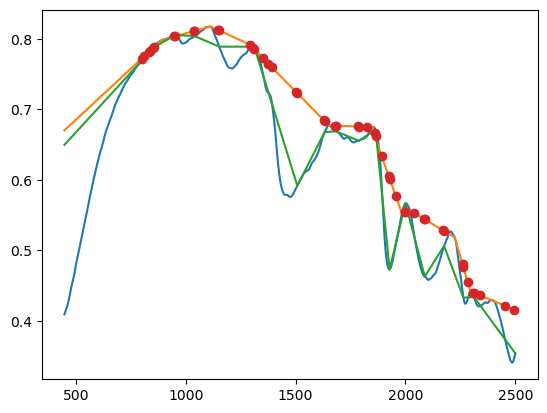

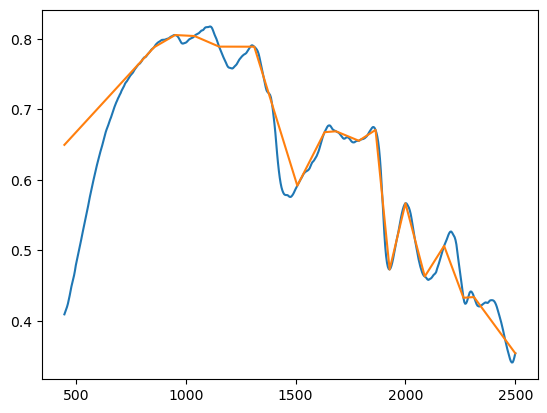

In [121]:
curr_zero_crossings = check_zero_crossings(curr_pixel,
                                               curr_prelim)
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, upper_hull)
plt.plot(wav_array, lower_hull)

plt.plot(wav_array[curr_zero_crossings], 
         upper_hull[curr_zero_crossings],
        'o')

# for i in range(len(curr_zero_crossings)):
i = 0 
curr_ind = curr_zero_crossings[0]
# if 
# if len(curr_zero_crossings) > 1:


union_array = np.sort(np.unique(np.concatenate(peaks, curr_ind)))
curr_prelim = interpolate_linear(curr_pixel,
                                 union_array)

plt.figure()
plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, curr_prelim)

# check_zero_crossings(curr_pixel, curr_prelim)
